In [885]:
import numpy
import numpy as np 
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

%matplotlib inline

## Part 1: Wavelength solution of 1D Neon spectrum and blackbody temperature

In [886]:
bb_data = np.loadtxt('Group_P_BB.dat')
neon_spec = np.loadtxt('Ne_calib.dat')
d = fits.open('Near-infrared.fits')

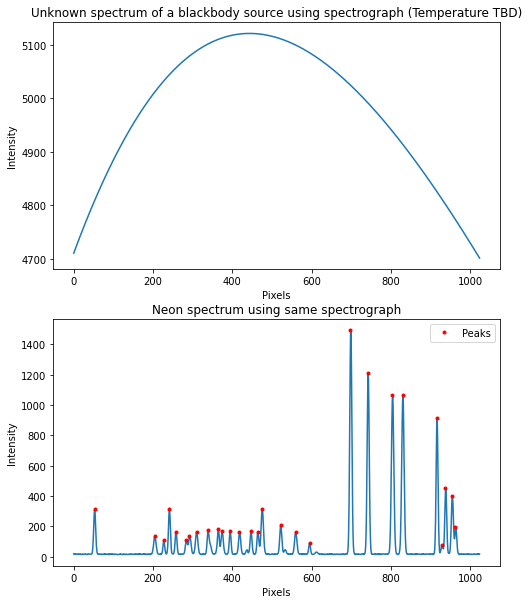

In [887]:
pixel = np.linspace(0, 1024, 1024)
peak_x, height = find_peaks(neon_spec, height=50) # some of the neon lines are not distinct, therefore I have chosen to only pick out ones that are above an intensity of 50

fig, ax = plt.subplots(2, 1, figsize=(8, 10))
ax[0].plot(pixel, bb_data)
ax[0].set_title("Unknown spectrum of a blackbody source using spectrograph (Temperature TBD)")
ax[0].set_xlabel("Pixels")
ax[0].set_ylabel("Intensity")
ax[1].plot(pixel, neon_spec)
ax[1].plot(peak_x, neon_spec[peak_x], '.', c='r', label="Peaks")
ax[1].set_title("Neon spectrum using same spectrograph")
ax[1].set_xlabel("Pixels")
ax[1].set_ylabel("Intensity")
ax[1].legend()

### Neon transitions
* wavelengths of the neon transitions that correspond to our spectrum peaks above

In [888]:
"""
By comparison, we can pick out the peaks in our Neon spectrum and match them with their respective wavelengths 
from Figure 5 of our lab manual. In our case, we picked out the peaks that had an intensity of over 50
"""
wl = np.array([540.056, 576.441, 582.015, 585.249, 588.189, 594.483, 597.553, 602.000, 607.433, 614.306, 616.359,
               621.728, 626.649, 633.442, 638.299, 640.225, 650.653, 659.895, 667.828, 692.947, 703.241, 717.394,
               724.512, 743.890, 747.244, 748.887, 753.577, 754.404])

### Centroids
* determining the centroids of the peaks

In [889]:
centroid = []
neon_spec = list((np.array(neon_spec)).astype(int))
pixel = list(pixel)

for i in range(len(peak_x)):
    intensity = []
    x = []
    
    max_intensity = neon_spec[peak_x[i]]
    half_intensity = neon_spec[peak_x[i]] / 2
    
    intensity.append(max_intensity)
    x.append(peak_x[i])
    
    for deviation in range(1,50):
        if neon_spec[peak_x[i] + deviation] > half_intensity and neon_spec[peak_x[i] - deviation] > half_intensity:
            intensity.append(neon_spec[peak_x[i] + deviation])
            x.append(peak_x[i] + deviation)
            intensity.append(neon_spec[peak_x[i] - deviation])
            x.append(peak_x[i] - deviation)
        else: 
            break
            
    product = np.dot(intensity, x) / np.sum(intensity)
    centroid.append(product)

centroid = np.array(centroid)
print(centroid)

[ 52.93387816 204.83688833 227.02882483 241.0527881  257.95325779
 284.12222222 292.08633094 309.91640543 339.01522843 364.16751918
 374.02081165 394.11189802 418.09110629 446.9930265  464.07103064
 475.08443709 521.94148472 559.82996812 594.88630491 698.12359377
 742.06595501 803.9399177  829.92377646 915.95210828 928.09850746
 937.92677824 954.12185355 962.96622889]


In [890]:
neon_spec = np.array(neon_spec)

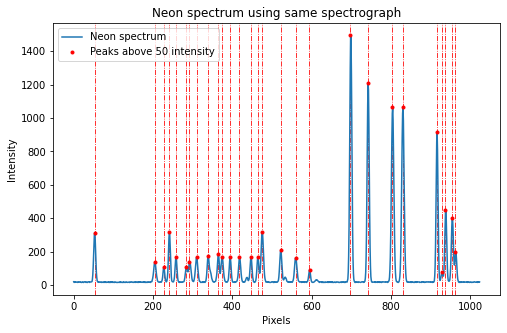

In [901]:
plt.figure(figsize=[8,5])
for i in range(len(centroid)):
    plt.axvline(centroid[i], ls='-.', c='r', linewidth=0.8)
    
plt.plot(pixel, neon_spec, label="Neon spectrum")
plt.plot(peak_x, neon_spec[peak_x], '.', c='r',label="Peaks above 50 intensity")
plt.title("Neon spectrum using same spectrograph")
plt.xlabel("Pixels")
plt.ylabel("Intensity")
plt.legend()
plt.show()

### Straight line fit
* fitting pixel position of the spectrograph to the respective wavelength

In [892]:
# y = mx + b
x = centroid
y = wl
nx = len(centroid)

#define square fit function
#matrices

ma = np.array([[np.sum(x**2), np.sum(x)], [np.sum(x), nx]])
mc = np.array([np.sum(x*y), np.sum(y)])

#inverse ma matrix
ma_inv = np.linalg.inv(ma)
md = np.dot(ma_inv, mc)

m = md[0]
b = md[1]

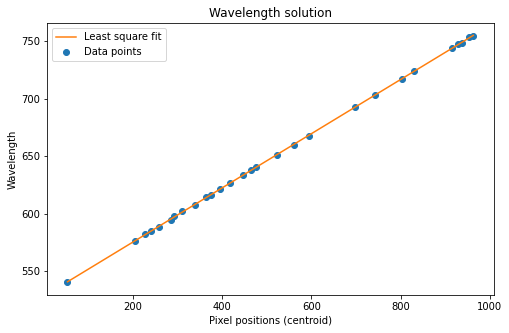

In [893]:
plt.figure(figsize=[8,5])
plt.scatter(centroid, wl, label="Data points")
plt.plot(x, m*x + b, c='C1', label="Least square fit")
plt.title("Wavelength solution")
plt.xlabel("Pixel positions (centroid)")
plt.ylabel("Wavelength")
plt.legend()

### Unknown Blackbody Source

The maximum intensity occurs at wavelength 443 pixels with intensity 5121.0


Text(0, 0.5, 'Wavelength')

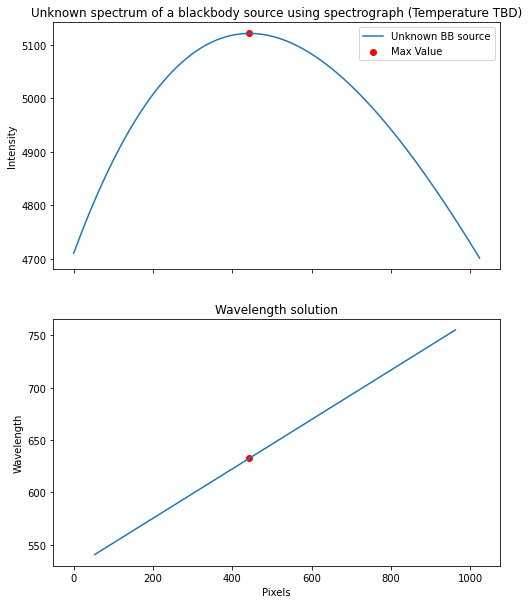

In [894]:
bb_max_x = list(bb_data).index(max(bb_data))
bb_max = m * bb_max_x + b
#centroid_space = np.linspace(max)
print("The maximum intensity occurs at wavelength", bb_max_x, "pixels with intensity", bb_data[bb_max_x])

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8,10), sharex=True)
ax[0].plot(pixel, bb_data, label="Unknown BB source")
ax[0].scatter(pixel[bb_max_x], bb_data[bb_max_x], c='r', label="Max Value")
ax[0].set_title("Unknown spectrum of a blackbody source using spectrograph (Temperature TBD)")
ax[0].set_ylabel("Intensity")
ax[0].legend()
ax[1].plot(centroid, m*centroid+b)
ax[1].scatter(bb_max_x, bb_max, c='r')
ax[1].set_title("Wavelength solution")
ax[1].set_xlabel("Pixels")
ax[1].set_ylabel("Wavelength")

In [895]:
def weins(lambda_max, b=2.898e-3):
    T = b / lambda_max #constant in units of m K
    return T

In [748]:
bb_temp = weins(bb_max * 1e-9) #to convert from nm to m
print("The blackbody temperature is", bb_temp,"kelvin")

The blackbody temperature is 4581.227244923344 kelvin


## Part 2: Wavelength solution of 2D spectra using OH telluric skylines

In [915]:
header = d[0].header

header

SIMPLE  =                    T / Written by IDL:  Sat Dec  3 12:02:39 2005      
BITPIX  =                   32                                                  
NAXIS   =                    3                                                  
NAXIS1  =                  256                                                  
NAXIS2  =                  256                                                  
NAXIS3  =                    1                                                  
                                                                                
RA      = '18:11:34.40       '          / Tel. right ascension in hh:mm:ss.ss   
DEC     = '-19:26:35.7       '          / Tel. declination in ddd:mm:ss.s       
HA      = '+00:02:17.5       '          / Hour angle in hh:mm:ss.s              
UT      = '03:47:36.7        '          / Universal time in hh:mm:ss.s          
LST     = '18:14:12.4        '          / Local siderial time in hh:mm:ss.s     
EPOCH   =          2000.0000

In [916]:
data = d[0].data
flip_data = np.flip(data, axis=1)
data[0].shape 

(256, 256)

### Defining our box

In [917]:
start, stop = 135, 150 #spatial width

(data[0][:, start:stop]).shape #box size: 15 spatial dimension, 256 spectral dimension (y-axis pixel)

(256, 15)

In [918]:
print(data[0][:, start:stop]) 
#print(data[0][:, stop])

[[ 108  144  137 ...   97   11  -10]
 [1849  382  314 ...  261  303  370]
 [ 361  344  269 ...  434  192  402]
 ...
 [2068 2206 2189 ... 1946 2034 1991]
 [2331 2152 2011 ... 1939 1994 2038]
 [2428 2349 2684 ... 2280 2389 2390]]


In [919]:
median = []
for i in range(len(data[0])): #in each row (spectral), take the median value across the width (spatial)
    m = np.median(data[0][i, start:stop])
    median.append(m)

In [920]:
median = np.array(median)
true_median = median[20:230] #we will only use the spectral width from 20 - 230

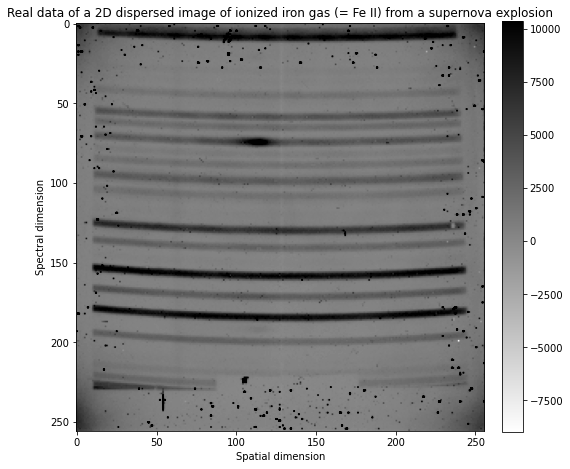

In [921]:
plt.figure(figsize=(8, 8))
# set the scale so the brightet white color represent the 99 percentile of the data instead of the outliers
# set the colormap (cmap) to greyscale
d = plt.imshow(flip_data[0], vmax=np.percentile(data[0], 99), cmap="binary")
plt.title("Real data of a 2D dispersed image of ionized iron gas (= Fe II) from a supernova explosion")
plt.xlabel("Spatial dimension")
plt.ylabel("Spectral dimension")
plt.colorbar(d, fraction=0.046, pad=0.04)
plt.show()

In [922]:
x = np.linspace(20, 229, 210)
peak_oh, height = find_peaks(true_median, height=1000) #find peaks
print("Peak OH x values:",peak_oh)
print("Corresponding intensities:",true_median[peak_oh])

Peak OH x values: [ 35  51  63  77  94 105 126 136 145 161 170 176 189]
Corresponding intensities: [2536. 9408. 3304. 9999. 2808. 6822. 1929. 3228. 1878. 4170. 2147. 3731.
 1876.]


In [923]:
"""
Through comparison, we identified five more OH telluric skylines based on their relative intensities with the 
surrounding wavelengths. Since we were only able to identify a total of ten OH lines, the other peaks in the
figure above must be eliminated (35, 170, 189)
"""

peak_oh = np.delete(peak_oh, [0, 10, 12])
print(peak_oh)

[ 51  63  77  94 105 126 136 145 161 176]


### Centroiding

In [924]:
#neon_spec -> true_median
#x -> pos
#peak_x -> peak_oh

centroids = []
true_median = true_median.astype(int)
#x = list(x)

for i in range(len(peak_oh)):
    intensity = []
    pos = []
    
    max_intensity = true_median[peak_oh[i]]
    half_intensity = max_intensity / 2
    
    intensity.append(max_intensity)
    pos.append(peak_oh[i])
    
    for deviation in range(1,100):
        if true_median[peak_oh[i] + deviation] > half_intensity and true_median[peak_oh[i] - deviation] > \
        half_intensity:
            intensity.append(true_median[peak_oh[i] + deviation])
            pos.append(peak_oh[i] + deviation)
            intensity.append(true_median[peak_oh[i] - deviation])
            pos.append(peak_oh[i] - deviation)
        else: 
            break
            
    product = np.dot(intensity, pos) / np.sum(intensity)
    centroids.append(product)

centroids = (np.array(centroids))
centroids = centroids + 20

print(centroids)

[ 70.93892008  83.07714192  96.92294101 114.03911594 124.93409618
 146.16599388 155.94148711 165.09324009 180.89560976 196.02933089]


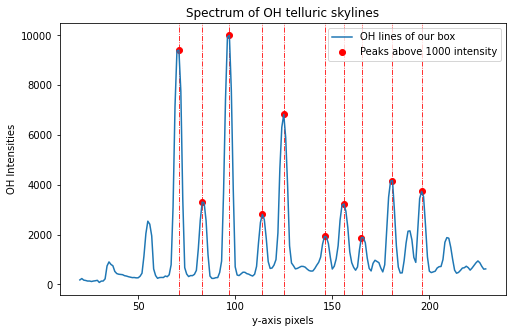

In [925]:
plt.figure(figsize=(8,5))

for i in range(len(centroids)):
    plt.axvline((centroids[i]), ls='-.', c='r', linewidth=0.8)
    
plt.plot(x, true_median, label="OH lines of our box")
plt.scatter(peak_oh + 20, true_median[peak_oh], c='r', label="Peaks above 1000 intensity")
plt.title("Spectrum of OH telluric skylines")
plt.xlabel("y-axis pixels")
plt.ylabel("OH Intensities")
plt.legend()

In [926]:
#plt.figure(figsize=(8,5))
#plt.plot(x, true_median)
#plt.scatter(peak_oh + 20, true_median[peak_oh], c='r', label="Peaks above 1000 intensity")
#plt.title("Identified spectrum of OH telluric skylines")
#plt.xlabel("y-axis pixels")
#plt.ylabel("OH Intensities")
#plt.legend()

### Define second and third degree polynomial

In [927]:
def degree3(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d

def degree2(x, a, b, c):
    return a*x**2 + b*x + c

### Plotting wavelength as a function of the y-axis pixels

Text(0.5, 0, 'y-axis pixels')

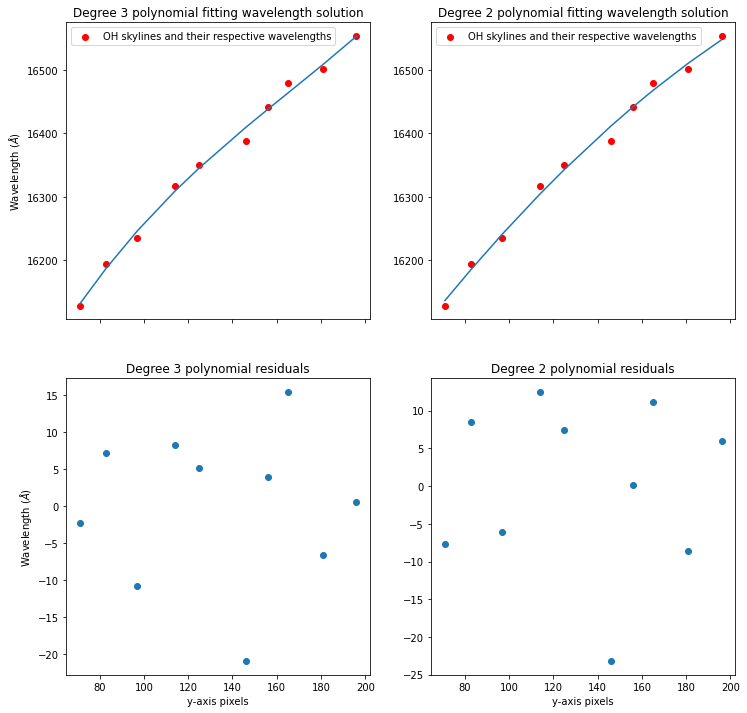

In [928]:
wavelength = np.array([16128.608, 16194.615, 16235.376, 16317.161, 16350.650, 16388.492, 16442.115, 16479.061,
                       16502.365, 16553.814])

"""
The polynomial fitting can be done with scipy.optimize.curve_fit or np.polyfit. As seen below, both methods give
the same results.
"""

#scipy.optimize.curve_fit
popt, pcov = curve_fit(degree3, x[peak_oh], wavelength)
popt2, pcov2 = curve_fit(degree2, x[peak_oh], wavelength)

#np.polyfit
fit3 = np.polyfit(x[peak_oh], wavelength, 3)
fit2 = np.polyfit(x[peak_oh], wavelength, 2)

y3 = degree3(x[peak_oh], *fit3)
y2 = degree2(x[peak_oh], *fit2)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 12), sharex=True)
ax[0,0].scatter(x[peak_oh], wavelength, c='r', label="OH skylines and their respective wavelengths")
ax[0,0].plot(x[peak_oh], degree3(x[peak_oh], *popt))
#ax[0,0].plot(x[peak_oh], y3)
ax[0,0].set_title("Degree 3 polynomial fitting wavelength solution")
#ax[0,0].set_xlabel("y-axis pixels")
ax[0,0].set_ylabel(r"Wavelength ($\AA$)")
ax[0,0].legend()

ax[0,1].scatter(x[peak_oh], wavelength, c='r', label="OH skylines and their respective wavelengths")
ax[0,1].plot(x[peak_oh], degree2(x[peak_oh], *popt2))
#ax[0,1].plot(x[peak_oh], y2)
ax[0,1].set_title("Degree 2 polynomial fitting wavelength solution")
#ax[0,1].set_xlabel("y-axis pixels")
#ax[0,1].set_ylabel(r"Wavelength ($\AA$)")
ax[0,1].legend()

#residuals
ax[1,0].scatter(x[peak_oh], wavelength - degree3(x[peak_oh], *popt))
#ax[1,0].scatter(x[peak_oh], wavelength - y3)
ax[1,0].set_title("Degree 3 polynomial residuals")
ax[1,0].set_xlabel("y-axis pixels")
ax[1,0].set_ylabel(r"Wavelength ($\AA$)")

ax[1,1].scatter(x[peak_oh], wavelength - degree2(x[peak_oh], *popt2))
#ax[1,1].scatter(x[peak_oh], wavelength - y2)
ax[1,1].set_title("Degree 2 polynomial residuals")
ax[1,1].set_xlabel("y-axis pixels")
#ax[0,1].set_ylabel(r"Wavelength ($\AA$)")

### Goodness of fit

In [929]:
"""
We can calculate the chi squared value of our measurement to see how well our fit is 
"""

def chi2(y_measured, y_predicted, errors):
    return np.sum((y_measured - y_predicted)**2 / errors**2)

def chi2reduced(y_measured, y_predicted, errors, number_of_parameters):
    return chi2(y_measured, y_predicted, errors) / (y_measured.size - number_of_parameters)

In [931]:
errors = np.abs(wavelength - degree3(x[peak_oh], *popt))

chi_squared = chi2(wavelength, degree3(x[peak_oh], *popt), errors)
print("Chi squared value is ", chi_squared)
reduced_chi = chi2reduced(wavelength, degree3(x[peak_oh], *popt), errors, 1)
print("Reduced chi squared is", reduced_chi)

Chi squared value is  10.0
Reduced chi squared is 1.1111111111111112


### Iron Emission

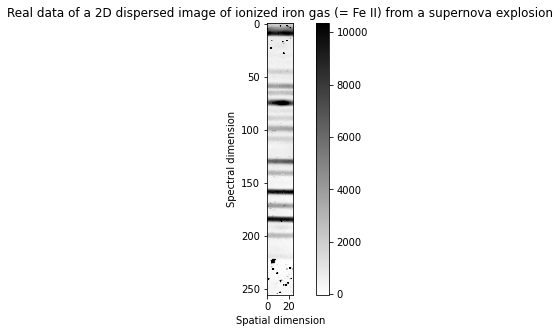

In [835]:
plt.figure(figsize=(10, 5))
# set the scale so the brightet white color represent the 99 percentile of the data instead of the outliers
# set the colormap (cmap) to greyscale
d = plt.imshow(flip_data[0][:, 100:125], vmax=np.percentile(data[0], 99), cmap="binary")
plt.title("Real data of a 2D dispersed image of ionized iron gas (= Fe II) from a supernova explosion")
plt.xlabel("Spatial dimension")
plt.ylabel("Spectral dimension")
plt.colorbar(d, fraction=0.046, pad=0.04)
plt.show()

In [836]:
fe_median = []
for i in range(len(data[0])): #in each row (spectral), take the median value across the width (spatial)
    m = np.median(data[0][i, 100:125])
    fe_median.append(m)

In [837]:
fe_median = np.array(fe_median)
true_fe_median = fe_median[20:230] #we will only use the spectral width from 20 - 230

In [838]:
peak_fe, height = find_peaks(true_fe_median, height=10000) #find peaks
print("Peak Fe x values:",peak_fe)

Peak Fe x values: [ 51 160]


In [844]:
fe_centroids = []
true_fe_median = true_fe_median.astype(int)
#x = list(x)

for i in range(len(peak_fe)):
    intensity = []
    pos = []
    
    max_intensity = true_fe_median[peak_fe[i]]
    half_intensity = max_intensity / 2
    
    intensity.append(max_intensity)
    pos.append(peak_fe[i])
    
    for deviation in range(1,100):
        if true_fe_median[peak_fe[i] + deviation] > half_intensity and true_fe_median[peak_fe[i] - deviation] > \
        half_intensity:
            intensity.append(true_fe_median[peak_fe[i] + deviation])
            pos.append(peak_fe[i] + deviation)
            intensity.append(true_fe_median[peak_fe[i] - deviation])
            pos.append(peak_fe[i] - deviation)
        else: 
            break
            
    product = np.dot(intensity, pos) / np.sum(intensity)
    fe_centroids.append(product)

fe_centroids = (np.array(fe_centroids) + 20)

print(fe_centroids)

[ 70.9706644  180.07495138]


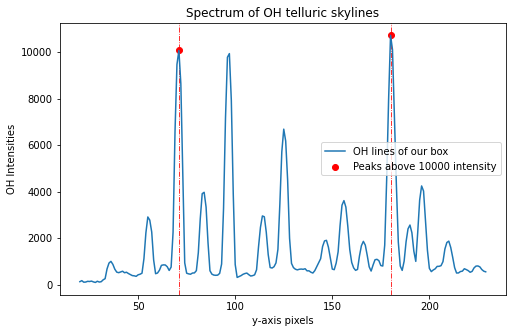

In [847]:
plt.figure(figsize=(8,5))

for i in range(len(fe_centroids)):
    plt.axvline((fe_centroids[i]), ls='-.', c='r', linewidth=0.8)
    
plt.plot(x, true_fe_median, label="OH lines of our box")
plt.scatter(peak_fe+20, true_fe_median[peak_fe], c='r', label="Peaks above 10000 intensity")
plt.title("Spectrum of OH telluric skylines")
plt.xlabel("y-axis pixels")
plt.ylabel("OH Intensities")
plt.legend()

In [906]:
"""
From the graph above, we can locate our Fe II emission to be at 180.07495138 pixels. Below we determine its 
position and calculate its velocity
"""
fe = fe_centroids[1]
fe_wavelength = degree2(fe, *fit2)
fe_wavelength = fe_wavelength*1e-10
print(fe_wavelength, "m")

fe_intrinsic = 1.6439981*1e-6

1.650859817363108e-06 m


In [907]:
def velocity(intrinsic, observed, c=3e8):
    return (c*(np.abs(intrinsic - observed))) / intrinsic

In [908]:
print("Speed of Fe II emission is then", velocity(fe_intrinsic, fe_wavelength), "m/s")

Speed of Fe II emission is then 1252139.652066794 m/s
